# cardiorespiratory fitness

In [1]:
import yaml
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import stemgraphic
import functools

from pathlib import Path
from itertools import compress
from sklearn.cluster import KMeans
from scipy import signal
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from functools import reduce

%matplotlib inline

Paths to phenotype data and project directories

In [2]:
wrk_dir = Path('.')

with open(wrk_dir / 'config/path.yaml') as f:
    path = yaml.full_load(f)

app_dir = Path(path['application'])
prj_dir = Path(path['project'])

phe_dir = app_dir / 'phenotypes'

Read field look-up table and phenotype data. (This data was prepared using ukbkings, R/fields.R)

In [3]:
field_files = glob.glob(str(phe_dir / '*field_finder.txt'))

f = pd.concat((pd.read_csv(f, sep='\t', header=0) for f in field_files), ignore_index=True)

col_type = {
        'Sequence': 'Int64',
        'Integer': 'Int64',
        'Categorical (single)': 'str',
        'Categorical (multiple)': 'str',
        'Continuous': 'float',
        'Text': 'str',
        'Date': 'str',
        'Time': 'str',
        'Compound': 'str',
        'Binary object': 'str',
        'Records': 'str',
        'Curve': 'str'
}

f['py_type'] = [col_type[t] for t in f['ukb_type']]

df = pd.read_csv(prj_dir / 'data/pheno/crf.pa.csv',
                 dtype=dict(zip(f['field'], f['py_type'])))

# Update columns to descriptive names
fields = df.columns.tolist()
f = f.loc[f.field.isin(fields), ].drop_duplicates()
df.columns = np.ravel([f.loc[f.field == col, 'name'].tolist() for col in df.columns]).tolist()

# Clean up names
char_to_replace = {'(': '', ')': '', '/': '_'}
df.columns = [name.translate(str.maketrans(char_to_replace)) for name in df.columns.to_list()]

## CRF phenotype QC

Read fam, sample, and sqc files for genetic metadata sample QC

In [4]:
fam_col_names = ['fid', 'iid', 'pid', 'mid', 'sex', 'phe']
fam = pd.read_csv(app_dir / 'genotyped/wukb13427_cal_chr22_v2_s488264.fam',
                  sep=' ', header=None, names=fam_col_names)

sample_col_names = ['fid', 'iid', 'miss', 'sex']
sample_file = pd.read_csv(app_dir / 'imputed/wukb13427_imp_chr22_v3_s487296.sample',
                          sep=' ', header=None, names=sample_col_names,
                          skiprows=[0, 1])

sqc_col_names = list(
    ['x1', 'x2', 'genotyping.array', 'Batch', 'Plate.Name', 'Well', 'Cluster.CR', 'dQC', 'Internal.Pico..ng.uL.',
     'Submitted.Gender', 'Inferred.Gender', 'X.intensity', 'Y.intensity', 'Submitted.Plate.Name', 'Submitted.Well',
     'sample.qc.missing.rate', 'heterozygosity', 'heterozygosity.pc.corrected', 'het.missing.outliers',
     'putative.sex.chromosome.aneuploidy', 'in.kinship.table', 'excluded.from.kinship.inference', 'excess.relatives',
     'in.white.British.ancestry.subset', 'used.in.pca.calculation'] +
    [f'{a}{b}' for a, b in zip(['pc'] * 40, list(range(1, 40 + 1)))] + # 26:65
    ['in.Phasing.Input.chr1_22', 'in.Phasing.Input.chrX', 'in.Phasing.Input.chrXY'])

sqc_col_names = [col_name.lower().replace('.', '_') for col_name in sqc_col_names] 
sqc = pd.read_csv(app_dir / 'imputed/ukb_sqc_v2.txt', sep=' ', header=None, names=sqc_col_names)

# Identify EUR sample by 4-means clustering
model = KMeans(4).fit(sqc.loc[:, ['pc1', 'pc2']])
sqc['pop'] = model.labels_
sqc = sqc[['genotyping_array', 'submitted_gender', 'inferred_gender',
           'het_missing_outliers', 'putative_sex_chromosome_aneuploidy',
           'excess_relatives', 'pop']]

# BOLT-LMM requires sample to be in both fam and sample files
meta = pd.merge(sample_file[['fid', 'iid']], fam.join(sqc), on=('fid', 'iid'), how='inner')

df = pd.merge(df, meta, left_on='eid', right_on='fid', how='inner')

Filter and select variables

In [5]:
df = df[(
    (df['submitted_gender'] == df['inferred_gender']) &
    (df['excess_relatives'] == 0) &
    (df['putative_sex_chromosome_aneuploidy'] == 0) &
    (df['het_missing_outliers'] == 0) &
    (df['pop'] == df['pop'].value_counts().idxmax())
)]

print(df['program_category_f6024_0_0'].value_counts())
print(df['program_category_f6024_1_0'].value_counts())

### Risk category and protocol

|code|risk|category|ramp|
|----|----|--------|----|
|1|minimal	|Category 1, cycle rising to 50% level|high|
|2|small	|Category 2, cycle rising to 35% level|low|
|3|medium	|Category 3, cycle at constant level|flat|

Test ramps 'flat' (6 mins constant WR), 'low' (2 min constant WR, 4 mins ramped WR), and 'high' (2 min constant WR, 4 mins ramped WR) as described in __Figure 1__ CRF validation paper.

In [6]:
risk = {'1': 'minimal', '2': 'small', '3': 'medium', '4': 'high', '-1': None}

df['program_category_f6024_0_0'] = df['program_category_f6024_0_0'].replace(risk)
df['program_category_f6024_1_0'] = df['program_category_f6024_1_0'].replace(risk)

crf_0 = df.loc[df.program_category_f6024_0_0.isin(['minimal', 'small', 'medium']), :]
crf_1 = df.loc[df.program_category_f6024_1_0.isin(['minimal', 'small', 'medium']), :]

print(crf_0['program_category_f6024_0_0'].value_counts(), '\n')
print(crf_1['program_category_f6024_1_0'].value_counts(), '\n')

In [ ]:
print('Initial assessment with assessment centre age:')
print(crf_0.dropna(subset=['age_when_attended_assessment_centre_f21003_0_0'])['program_category_f6024_0_0'].value_counts(), '\n')

print('First repeat assessment with assessment centre age:')
print(crf_1.dropna(subset=['age_when_attended_assessment_centre_f21003_1_0'])['program_category_f6024_1_0'].value_counts(), '\n')

crf_0 = crf_0.dropna(subset=['age_when_attended_assessment_centre_f21003_0_0'])
crf_1 = crf_1.dropna(subset=['age_when_attended_assessment_centre_f21003_1_0'])

- for 'minimal' and 'small' risk, identify the 4-min ramp phase (above 2 min constant phase = 30 watts for women, 40 watts for men)
    - apply butterworth filter and modelling to ramp phase for minimal (rising to 50%) and small risk (rising to 35%)

- for 'medium', apply butterworth filter and modelling to full 6 min (constant)

- NB. resting pulse rate (f95, f102 measured during blood pressure measurement), not available.

- take resting heart rate from average of rest period?

>__Kim et al.__:
>
>In addition _\[to excluding 'high' risk and those ineligible for ECG\]_, we implemented
>
>- data cleaning and quality control procedures (__S3 Material in Appendix__).
>- Linear regression was performed to predict workload from heart rate (__S4 Material in Appendix__); 
>- the established linear relationship was then extrapolated to age-predicted maximum heart rate to estimate an individual’s maximal power (watts) as an indicator of CRF.
>- Consolidation procedures were applied to obtain the most robust CRF estimate (__S5 Material in Appendix__).
>- To account for differences in body size, CRF was expressed as maximal power per fat-free mass (kg) (i.e. body mass–fat mass), the latter measured using bio-impedance analysis (Tanita BC-418MA).
>- Individuals with heart rate missing for >2 min (50%) during the ramp phase (n = 116) or with maximum power of 0 (n = 156; a sign of the cycle ergometer/ECG acquisition system malfunctioning) or outliers with >20 watts/fat-free mass (n = 41) were excluded from analyses.

In [8]:
crf_test_method = {'1': 'Bicycle', '2': 'Resting only', '6': 'Not performed - equipment failure',
'7': 'Not performed - other reason'}

# Instance 0
crf_0 = crf_0.replace({'ecg_bike_method_for_fitness_test_f6019_0_0': crf_test_method})
crf_0 = crf_0.loc[crf_0['ecg_bike_method_for_fitness_test_f6019_0_0'].isin(['Bicycle']), :]

print('Initial assessment:')
print(crf_0['program_category_f6024_0_0'].value_counts(), '\n')


# Instance 1
crf_1 = crf_1.replace({'ecg_bike_method_for_fitness_test_f6019_1_0': crf_test_method})
crf_1 = crf_1.loc[crf_1['ecg_bike_method_for_fitness_test_f6019_1_0'].isin(['Bicycle']), :]

print('First repeat assessment:')
print(crf_1['program_category_f6024_1_0'].value_counts())

Initial assessment:
minimal    50809
small       7700
medium      1885
Name: program_category_f6024_0_0, dtype: int64 

First repeat assessment:
minimal    14564
small       2374
medium       520
Name: program_category_f6024_1_0, dtype: int64


## Test_0 sample

Small participant sample to test modelling

In [9]:
# crf_0 = crf_0.sample(1000)
# crf_1 = crf_1.sample(1000)

Make repeated cycle test measures long

In [10]:
def melt_cycle_ramp_test(wide, name):
    """
    Make wide cycle measures long.
    
    wide : pd.DataFrame
        Repeated cycle measures in "wide" format (i.e., one per column).
    name : str
        Name of the repeated measure.
    """
    df = wide.stack().reset_index()
    df.columns = ['eid', 'measure_trend', name]
    df['trend'] = df.measure_trend.str.split('_').str[-1].astype('int64')
    df = df.drop('measure_trend', axis='columns')
    df = df.set_index(['eid', 'trend']).sort_index()
    return df

In [11]:
# Instance 0
crf_0 = crf_0.set_index('eid')

phase_0, speed_0, heart_0, load_0 = map(
    lambda f: crf_0.filter(regex=f, axis=1),
    ['^ecg_trend_phase_name_f5987_0',
     '^bicycle_speed_f5985_0',
     '^ecg_heart_rate_f5983_0',
     '^ecg_load_f5984_0'])

phase_long_0, speed_long_0, heart_long_0, load_long_0 = map(
    lambda x, y: melt_cycle_ramp_test(x, y),
    [phase_0, speed_0, heart_0, load_0],
    ['phase', 'speed', 'heart', 'load'])

cycle_long_0 = functools.reduce(
    lambda x, y: x.merge(y, how='outer', left_index=True, right_index=True),
    [phase_long_0, speed_long_0, heart_long_0, load_long_0])


# Instance 1
crf_1 = crf_1.set_index('eid')

phase_1, speed_1, heart_1, load_1 = map(
    lambda f: crf_1.filter(regex=f, axis=1),
    ['^ecg_trend_phase_name_f5987_1',
     '^bicycle_speed_f5985_1',
     '^ecg_heart_rate_f5983_1',
     '^ecg_load_f5984_1'])

phase_long_1, speed_long_1, heart_long_1, load_long_1 = map(
    lambda x, y: melt_cycle_ramp_test(x, y),
    [phase_1, speed_1, heart_1, load_1],
    ['phase', 'speed', 'heart', 'load'])

cycle_long_1 = functools.reduce(
    lambda x, y: x.merge(y, how='outer', left_index=True, right_index=True),
    [phase_long_1, speed_long_1, heart_long_1, load_long_1])

Plot work rate flat, low and high ramp

In [12]:
# plt.figure()
# fig = cycle_long_0.reset_index().plot(x='trend', y='load', linewidth=0.5, legend=None)
# fig.set(ylabel='load')

Select 'Exercise' phase and speed (cadence) in range 35 - 125 RPM

In [13]:
# Instance 0
exercise_long_0 = (cycle_long_0.loc[
    (cycle_long_0['phase'] == 'Exercise') &
    (cycle_long_0['speed'] >= 35) &
    (cycle_long_0['speed'] <= 125) &
    (cycle_long_0['load'] >= 30)].reset_index())

pretest_long_0 = (cycle_long_0.loc[
    (cycle_long_0['phase'] == 'Pretest') &
    (cycle_long_0['speed'] == 0)].reset_index())
    
print('Initial assessment:')
print(exercise_long_0['eid'].nunique(), '\n')


# Instance 1
exercise_long_1 = (cycle_long_1.loc[
    (cycle_long_1['phase'] == 'Exercise') &
    (cycle_long_1['speed'] >= 35) &
    (cycle_long_1['speed'] <= 125) &
    (cycle_long_1['load'] >= 30)].reset_index())

pretest_long_1 = (cycle_long_1.loc[
    (cycle_long_1['phase'] == 'Pretest') &
    (cycle_long_1['speed'] == 0)].reset_index())
    
print('First repeat assessment:')
print(exercise_long_1['eid'].nunique(), '\n')

Initial assessment:
60070 

First repeat assessment:
17409 



## Ramp

Include sex and risk category

- keep only 'ramp' for risk categories with a ramp ('minimal' and 'small'), i.e., females > 30 watts, males > 40 watts
- missing HR: Drop? Impute (backfill)?
- compare fit of linear model of HR (distribution of $R^2$) across flat and ramped phase combined (previous approach)


In [14]:
df['eid'] = df['eid'].astype(int)


# Instance 0
exercise_long_0 = (exercise_long_0
                   .set_index('eid')
                   .join(df[['eid', 'inferred_gender', 'program_category_f6024_0_0']].set_index('eid'))
                   .rename({'inferred_gender': 'gender', 'program_category_f6024_0_0': 'risk'}, axis='columns')
                   .reset_index())

exercise_full_0 = (exercise_long_0
                   .set_index('eid')
                   .groupby('eid')
                   .filter(lambda x: x['heart'].dropna(axis='index').shape[0] > 20)
                   .reset_index())

exercise_ramp_0 = (exercise_long_0
                   .drop(exercise_long_0[(
                       ((exercise_long_0['risk']=='minimal') | (exercise_long_0['risk'] == 'small')) &
                       (
                           ((exercise_long_0['gender']=='F') & (exercise_long_0['load'] <= 30)) |
                           ((exercise_long_0['gender']=='M') & (exercise_long_0['load'] <= 40))
                       ))].index)
                   .set_index('eid')
                   .groupby('eid')
                   .filter(lambda x: x['heart'].dropna(axis='index').shape[0] > 20)
                   .reset_index())

print('Initial assessment:')
print('Full (constant + ramp, for categories with a ramp):', exercise_full_0['eid'].nunique(), '\n')
print('Ramp only (for categories with a ramp):', exercise_ramp_0['eid'].nunique(), '\n')


# Instance 1
exercise_long_1 = (exercise_long_1
                   .set_index('eid')
                   .join(df[['eid', 'inferred_gender', 'program_category_f6024_1_0']].set_index('eid'))
                   .rename({'inferred_gender': 'gender', 'program_category_f6024_1_0': 'risk'}, axis='columns')
                   .reset_index())

exercise_full_1 = (exercise_long_1
                   .set_index('eid')
                   .groupby('eid')
                   .filter(lambda x: x['heart'].dropna(axis='index').shape[0] > 20)
                   .reset_index())

exercise_ramp_1 = (exercise_long_1
                   .drop(exercise_long_1[(
                       ((exercise_long_1['risk']=='minimal') | (exercise_long_1['risk'] == 'small')) &
                       (
                           ((exercise_long_1['gender']=='F') & (exercise_long_1['load'] <= 30)) |
                           ((exercise_long_1['gender']=='M') & (exercise_long_1['load'] <= 40))
                       ))].index)
                   .set_index('eid')
                   .groupby('eid')
                   .filter(lambda x: x['heart'].dropna(axis='index').shape[0] > 20)
                   .reset_index())

print('First repeat assessment:')
print('Full (constant + ramp, for categories with a ramp):', exercise_full_1['eid'].nunique(), '\n')
print('Ramp only (for categories with a ramp):', exercise_ramp_1['eid'].nunique(), '\n')

Initial assessment:
Full (constant + ramp, for categories with a ramp): 58538 

Ramp only (for categories with a ramp): 57604 

First repeat assessment:
Full (constant + ramp, for categories with a ramp): 17007 

Ramp only (for categories with a ramp): 16655 



## Signal processing

Heart rate signal processing with Butterworth low-pass filter

In [15]:
def butter_lowpass_filt(x, N=3, Wn=0.1):
    """
    x : pd.DataFrame
        With heart rate (in BPM) in column 'heart'.
    N, Wn : int, float
        signal.butter parameters
    Returns
    -------
    A pd.Dataframe with an additional column containing Butterworth filtered BPM
    """
    b, a = signal.butter(N=N, Wn=Wn)
    x_filtered = signal.filtfilt(b, a, x['heart'].values)
    return x.assign(heart_filt = x_filtered)

In [16]:
# Instance 0
exercise_full_processed_0 = (
    exercise_full_0.loc[exercise_full_0['heart'].dropna(axis='index').index]
    .groupby('eid')
    .apply(lambda x: butter_lowpass_filt(x))
    .set_index(['eid','trend']))

exercise_ramp_processed_0 = (
    exercise_ramp_0.loc[exercise_ramp_0['heart'].dropna(axis='index').index]
    .groupby('eid')
    .apply(lambda x: butter_lowpass_filt(x))
    .set_index(['eid','trend']))

exercise_full_processed_0 = exercise_full_processed_0.astype({'heart_filt': float})
exercise_ramp_processed_0 = exercise_ramp_processed_0.astype({'heart_filt': float})


# Instance 1
exercise_full_processed_1 = (
    exercise_full_1.loc[exercise_full_1['heart'].dropna(axis='index').index]
    .groupby('eid')
    .apply(lambda x: butter_lowpass_filt(x))
    .set_index(['eid','trend']))

exercise_ramp_processed_1 = (
    exercise_ramp_1.loc[exercise_ramp_1['heart'].dropna(axis='index').index]
    .groupby('eid')
    .apply(lambda x: butter_lowpass_filt(x))
    .set_index(['eid','trend']))

exercise_full_processed_1 = exercise_full_processed_1.astype({'heart_filt': float})
exercise_ramp_processed_1 = exercise_ramp_processed_1.astype({'heart_filt': float})

Count the number of measurements (trend entries) to include as covariate.

In [17]:
# trend count, i.e., number of observations

# Instance 0
exercise_ramp_trend_0 = (exercise_ramp_processed_0
                         .reset_index()
                         .groupby('eid')
                         .apply(len))

exercise_ramp_trend_0 = pd.DataFrame({'trend_0': exercise_ramp_trend_0})


#Instance 1
exercise_ramp_trend_1 = (exercise_ramp_processed_1
                         .reset_index()
                         .groupby('eid')
                         .apply(len))

exercise_ramp_trend_1 = pd.DataFrame({'trend_1': exercise_ramp_trend_1})

## Calculate CRF phenotypes

Fit a linear models:

- CRF-slope from heart rate ~ trend
- CRF-vo2max work rate ~ heart rate, to predict workrate at age estimated max heart rate

Include age, age-estimated max heart rate, sex, category, weight

In [18]:
# Instance 0
exercise_ramp_processed_0 = (exercise_ramp_processed_0
                             .reset_index()
                             .set_index('eid')
                             .join(df.set_index('eid')[['age_when_attended_assessment_centre_f21003_0_0', 'weight_f21002_0_0']]))


# Instance 1
exercise_ramp_processed_1 = (exercise_ramp_processed_1
                             .reset_index()
                             .set_index('eid')
                             .join(df.set_index('eid')[['age_when_attended_assessment_centre_f21003_1_0', 'weight_f21002_1_0']]))

### CRF-slope

In [19]:
import statsmodels.formula.api as smf


def ols_cycle(data, model):
    """Fits linear model and returns slope
    
    model: y ~ x
    """
    lm = smf.ols(model, data=data).fit()
    return lm


def sm_rsq(data, model):
    """Get slope of rsq ols
    
    model: y ~ x
    """
    rsq = ols_cycle(data, model).rsquared
    return rsq


def sm_slope(data, model, x_coef='trend'):
    """Get slope of sm ols
    
    model: y ~ x
    """
    slope = ols_cycle(data, model).params[x_coef]
    return slope

Set slope value $<= 0$ to missing

In [20]:
# Instance 0
exercise_ramp_slope_0 = (exercise_ramp_processed_0
                         .reset_index()
                         .groupby('eid')
                         .apply(lambda x: sm_slope(x, model='heart_filt ~ trend')))

exercise_ramp_slope_0 = pd.DataFrame({'s_0': exercise_ramp_slope_0})
exercise_ramp_slope_0['slope_0'] = np.where(exercise_ramp_slope_0['s_0'] <= 0, np.nan, exercise_ramp_slope_0['s_0'])
exercise_ramp_slope_0 = exercise_ramp_slope_0[['slope_0']]

# Instance 1
exercise_ramp_slope_1 = (exercise_ramp_processed_1
                         .reset_index()
                         .groupby('eid')
                         .apply(lambda x: sm_slope(x, model='heart_filt ~ trend')))

exercise_ramp_slope_1 = pd.DataFrame({'s_1': exercise_ramp_slope_1})
exercise_ramp_slope_1['slope_1'] = np.where(exercise_ramp_slope_1['s_1'] <= 0, np.nan, exercise_ramp_slope_1['s_1'])
exercise_ramp_slope_1 = exercise_ramp_slope_1[['slope_1']]

### CRF-vo2max

> Youngwon et al.: __CRF was expressed as maximal power per fat-free mass (kg)__ (i.e. body mass–fat mass) (...) Individuals with heart rate missing for 2 min (50%) during the ramp phase (n = 116) or with maximum power of 0 (n = 156; a sign of the cycle ergometer/ECG acquisition system malfunctioning) or outliers with 20 watts/fat-free mass (n = 40) were excluded from analyses.

ACSM energy expenditure from steady state test:

$vo_2max = \frac{10.8 x W}{K} + 7$

_Where_
- $W$ is maximum workrate in $watts$ (power?), extrapolated from the linear model $work rate = f(heart rate)$
- $K$ is weight in $kg$
- metric is $watts \cdot kg^{-1}$


Predicted WR at age-estimated HR max is set to missing where $<= 0$


In [21]:
def vo2max_cycle(data, model, age, weight):
    """Get vo2max from work rate ~ heart rate
    
    data: long-format dataframe of cycle ramp test measures
    model: formula e.g., y ~ x
    age: name of the age variable
    weight: name of the weight variable
    """
    try:
        df = data.dropna(subset=['load', 'heart_filt', age, weight])
        hrmax = 208 - (0.7 * df[age].iloc[0])
        lm = ols_cycle(df, model)
        wrmax = lm.predict({'heart_filt': [hrmax]})
        wrmax = np.nan if (wrmax.iloc[0] <= 0) else wrmax.iloc[0]
        vo2max = wrmax / df[weight].iloc[0]
        return vo2max
    except IndexError:
        return np.nan

In [33]:
# convert work rate to int for modelling

# Instance 0
exercise_ramp_processed_0 = exercise_ramp_processed_0.astype({'load': int})

exercise_ramp_vo2max_0 = (
    exercise_ramp_processed_0
    .reset_index()
    .groupby('eid')
    .apply(lambda x: vo2max_cycle(x, model='load ~ heart_filt', age='age_when_attended_assessment_centre_f21003_0_0', weight='weight_f21002_0_0'))
)


# Instance 1
exercise_ramp_processed_1 = exercise_ramp_processed_1.astype({'load': int})

exercise_ramp_vo2max_1 = (
    exercise_ramp_processed_1
    .reset_index()
    .groupby('eid')
    .apply(lambda x: vo2max_cycle(x, model='load ~ heart_filt', age='age_when_attended_assessment_centre_f21003_1_0', weight='weight_f21002_1_0'))
)

In [34]:
exercise_ramp_vo2max_0 = pd.DataFrame({'vo2max_0': exercise_ramp_vo2max_0})
exercise_ramp_vo2max_1 = pd.DataFrame({'vo2max_1': exercise_ramp_vo2max_1})

In [35]:
# sd_n = 6
# sd_out = np.mean(exercise_ramp_vo2max_0['vo2max']) + (np.std(exercise_ramp_vo2max_0['vo2max']) * sd_n)

# exercise_ramp_vo2max_0['vo2max'].plot.hist(bins=50, color='grey')
# plt.axvline(x=sd_out, color='red')

Combine instances

In [37]:
dfs_0 = [exercise_ramp_trend_0,
         exercise_ramp_slope_0,
         exercise_ramp_vo2max_0]

fitness_0 = reduce(lambda left,right: left.join(right, how='outer'), dfs_0)


dfs_1 = [exercise_ramp_trend_1,
         exercise_ramp_slope_1,
         exercise_ramp_vo2max_1]

fitness_1 = reduce(lambda left,right: left.join(right, how='outer'), dfs_1)

fitness = fitness_0.dropna().join(fitness_1.dropna(), how='outer')

if all(
    (fitness['slope_0'].isnull() == fitness['vo2max_0'].isnull()) &
    (fitness['slope_1'].isnull() == fitness['vo2max_1'].isnull())):
        fitness['slope'] = fitness['slope_0'].fillna(fitness['slope_1'])
        fitness['vo2max'] = fitness['vo2max_0'].fillna(fitness['vo2max_1'])
        fitness['trend'] = fitness['trend_0'].fillna(fitness['trend_1'])
        fitness['instance'] = fitness['slope_0'].isnull().replace({True: 1, False: 0})

fitness = fitness[['slope', 'vo2max', 'instance', 'trend']]

Correlation between vo2max and slope and min HR as a proxy for resting HR

In [ ]:
heart_filt_min = (exercise_full_processed_0
                  .groupby('eid')[['heart_filt']]
                  .head(n=1)
                  .rename({'heart_filt': 'heart_min'}, axis='columns')
                  .reset_index(level=1)
                  .drop('trend', axis='columns')
                  .join(fitness))

pearsonr(
    heart_filt_min[['heart_min', 'vo2max']].dropna().heart_min,
    heart_filt_min[['heart_min', 'vo2max']].dropna().vo2max)

pearsonr(
    heart_filt_min[['heart_min', 'slope']].dropna().heart_min,
    heart_filt_min[['heart_min', 'slope']].dropna().slope)

Include covariates

In [38]:
fitness = fitness.join(df
    .reset_index()
    .set_index('eid')[[
        'age_when_attended_assessment_centre_f21003_0_0',
        'inferred_gender',
        'body_mass_index_bmi_f21001_0_0',
        'genotyping_array',
        'uk_biobank_assessment_centre_f54_0_0',
        'smoking_status_f20116_0_0',
        'alcohol_drinker_status_f20117_0_0',
        'program_category_f6024_0_0',
        'age_when_attended_assessment_centre_f21003_1_0',
        'body_mass_index_bmi_f21001_1_0',
        'uk_biobank_assessment_centre_f54_1_0',
        'smoking_status_f20116_1_0',
        'alcohol_drinker_status_f20117_1_0',
        'program_category_f6024_1_0',
        'townsend_deprivation_index_at_recruitment_f189_0_0'
    ]])

fitness = fitness.rename({
        'age_when_attended_assessment_centre_f21003_0_0': 'age_0',
        'inferred_gender': 'sex',
        'body_mass_index_bmi_f21001_0_0': 'bmi_0',
        'genotyping_array': 'array',
        'uk_biobank_assessment_centre_f54_0_0': 'centre_0',
        'smoking_status_f20116_0_0': 'smoking_0',
        'alcohol_drinker_status_f20117_0_0': 'alcohol_0',
        'program_category_f6024_0_0': 'category_0',
        'age_when_attended_assessment_centre_f21003_1_0': 'age_1',
        'body_mass_index_bmi_f21001_1_0': 'bmi_1',
        'uk_biobank_assessment_centre_f54_1_0': 'centre_1',
        'smoking_status_f20116_1_0': 'smoking_1',
        'alcohol_drinker_status_f20117_1_0': 'alcohol_1',
        'program_category_f6024_1_0': 'category_1',
        'townsend_deprivation_index_at_recruitment_f189_0_0': 'deprivation'}, axis='columns')

Rename and recode variables

In [39]:
fitness['age'] = np.where(fitness['instance'] == 0, fitness['age_0'], fitness['age_1'])
fitness['bmi'] = np.where(fitness['instance'] == 0, fitness['bmi_0'], fitness['bmi_1'])
fitness['centre'] = np.where(fitness['instance'] == 0, fitness['centre_0'], fitness['centre_1'])
fitness['smoking'] = np.where(fitness['instance'] == 0, fitness['smoking_0'], fitness['smoking_1'])
fitness['alcohol'] = np.where(fitness['instance'] == 0, fitness['alcohol_0'], fitness['alcohol_1'])
fitness['category'] = np.where(fitness['instance'] == 0, fitness['category_0'], fitness['category_1'])

fitness = fitness.reset_index()

# BOLT-LMM pheno file requires header, with first 2 columns FID IID
fitness['FID'] = fitness['eid']
fitness = fitness.rename(columns={'eid': 'IID'})

fitness = fitness.replace({'sex': {'M': '1', 'F': '2'},
                           'array': {'UKBL': '0', 'UKBB': '1'},
                           'smoking': {'-3': 'NA'},
                           'alcohol': {'-3': 'NA'},
                           'category': {'minimal': 1, 'small': 2, 'medium': 3}})

fitness['mslope'] =  np.where(fitness['sex']=='1', fitness['slope'], np.nan)
fitness['fslope'] =  np.where(fitness['sex']=='2', fitness['slope'], np.nan)

fitness['mvo2max'] =  np.where(fitness['sex']=='1', fitness['vo2max'], np.nan)
fitness['fvo2max'] =  np.where(fitness['sex']=='2', fitness['vo2max'], np.nan)

slope = fitness[['FID', 'IID', 'slope', 'mslope', 'fslope', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol', 'deprivation']]
vo2max = fitness[['FID', 'IID', 'vo2max', 'mvo2max', 'fvo2max', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol', 'deprivation']]

<AxesSubplot:ylabel='Density'>

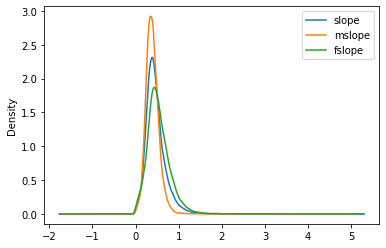

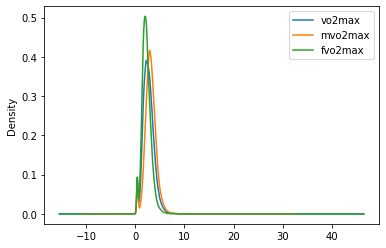

In [40]:
slope[['slope', 'mslope', 'fslope']].plot.kde()
vo2max[['vo2max', 'mvo2max', 'fvo2max']].plot.kde()

Write phenotype/covariate and keep files

In [41]:
# slope
(slope[slope['slope'].notnull()][['FID', 'IID', 'slope', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/slope.pheno', sep=' ', header=True, index=False, na_rep='NA'))

(slope[slope['mslope'].notnull()][['FID', 'IID', 'slope', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/slope.m.pheno', sep=' ', header=True, index=False, na_rep='NA'))

(slope[slope['fslope'].notnull()][['FID', 'IID', 'slope', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/slope.f.pheno', sep=' ', header=True, index=False, na_rep='NA'))

slope[['FID', 'IID']].to_csv('data/pheno/slope.keep', sep=' ', header=False, index=False)
slope[slope['mslope'].notnull()][['FID', 'IID']].to_csv('data/pheno/slope.m.keep', sep=' ', header=False, index=False)
slope[slope['fslope'].notnull()][['FID', 'IID']].to_csv('data/pheno/slope.f.keep', sep=' ', header=False, index=False)


# vo2max
(vo2max[vo2max['vo2max'].notnull()][['FID', 'IID', 'vo2max', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/vo2max.pheno', sep=' ', header=True, index=False, na_rep='NA'))

(vo2max[vo2max['mvo2max'].notnull()][['FID', 'IID', 'vo2max', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/vo2max.m.pheno', sep=' ', header=True, index=False, na_rep='NA'))

(vo2max[vo2max['fvo2max'].notnull()][['FID', 'IID', 'vo2max', 'age', 'sex', 'array', 'centre', 'trend', 'instance', 'category', 'bmi', 'smoking', 'alcohol']]
 .to_csv('data/pheno/vo2max.f.pheno', sep=' ', header=True, index=False, na_rep='NA'))

vo2max[['FID', 'IID']].to_csv('data/pheno/vo2max.keep', sep=' ', header=False, index=False)
vo2max[vo2max['mvo2max'].notnull()][['FID', 'IID']].to_csv('data/pheno/vo2max.m.keep', sep=' ', header=False, index=False)
vo2max[vo2max['fvo2max'].notnull()][['FID', 'IID']].to_csv('data/pheno/vo2max.f.keep', sep=' ', header=False, index=False)

In [42]:
%%bash

wc -l data/pheno/*pheno
wc -l data/pheno/*keep

   50332 data/pheno/pa.f.pheno
   39353 data/pheno/pa.m.pheno
   89684 data/pheno/pa.pheno
   36365 data/pheno/slope.f.pheno
   34420 data/pheno/slope.m.pheno
   70784 data/pheno/slope.pheno
   36365 data/pheno/vo2max.f.pheno
   34420 data/pheno/vo2max.m.pheno
   70784 data/pheno/vo2max.pheno
  462507 total
  50331 data/pheno/pa.f.keep
  89683 data/pheno/pa.keep
  39352 data/pheno/pa.m.keep
  36364 data/pheno/slope.f.keep
  70783 data/pheno/slope.keep
  34419 data/pheno/slope.m.keep
  36364 data/pheno/vo2max.f.keep
  70783 data/pheno/vo2max.keep
  34419 data/pheno/vo2max.m.keep
 462498 total
